## Behavioral cloning 
--- 

In [36]:
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import core, convolutional, pooling
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2, l1
from keras.optimizers import Adam, Nadam
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import skimage.transform as sktransform
import math
import numpy as np
import pandas as pd
from PIL import Image         
import cv2                 
import matplotlib.pyplot as plt
from os import getcwd
import os
import csv
import random
import matplotlib.image as mpimg
# Fix error with TF and Keras
import tensorflow as tf
#from tensorflow.python.ops import functional_ops as fn_ops
#tf.python.control_flow_ops = tf
% matplotlib inline

### Getting the data 

* 3 laps of center driving clock wise 
* 3 laps of center driving counter clock wise 

* recovery driving 

### Data loading 

Using pandas to load the data from the .csv file. the data are the centered images, the left images and the right images and their steering angle.

In [2]:
csv_path = './data/driving_log - Copie.csv'
local_data_path = '/data'
dir_abs_path = getcwd()

def change_dir(x):
    """
    Replace path of the a column of the dataframe
    example : C:\...\*\.jpg to *\.jpg
    """
    split = str(x).split('\\')
    filename = split[len(split)-1]
    dirname = split[len(split)-2]
    conca = os.path.join(dirname,filename)
    return conca

def load_data(csv_path):
    """
    Load data from the csv file 
    Returns Panda DataFrame containing all the data
    """
    #df = pd.io.parsers.read_csv(csv_path, delimiter=',', header=None, names = ['center','left','right',
    #                                                                           'steering','throttle','brake','speed'])
    df = pd.io.parsers.read_csv(csv_path, delimiter=',')
    return df


def convert(strr):
    return strr.replace("\\","/")

def combine_dataframe(condi=False):
    """
    Combine the multiple csv of data into a final dataframe
    """
    if condi == True :
        df1 = load_data(csv_path)
        df2 = load_data('./data/2/driving_log.csv')
        df3 = load_data('./data/3/driving_log.csv')
        df4 = load_data('./data/4/driving_log.csv')

        df2.center = df2.center.apply(change_dir)
        df2.left = df2.left.apply(change_dir)
        df2.right = df2.right.apply(change_dir)
        df2.center = df2.center.apply(convert)
        df2.left = df2.left.apply(convert)
        df2.right = df2.right.apply(convert)
        
        df3.center = df3.center.apply(change_dir)
        df3.left = df3.left.apply(change_dir)
        df3.right = df3.right.apply(change_dir)
        df3.center = df3.center.apply(convert)
        df3.left = df3.left.apply(convert)
        df3.right = df3.right.apply(convert)
        
        df4.center = df4.center.apply(change_dir)
        df4.left = df4.left.apply(change_dir)
        df4.right = df4.right.apply(change_dir)
        df4.center = df4.center.apply(convert)
        df4.left = df4.left.apply(convert)
        df4.right = df4.right.apply(convert)

        df = pd.DataFrame()
        df = df.append(df1, ignore_index= True)
        df = df.append(df2, ignore_index= True)
        df = df.append(df3, ignore_index= True)
        df = df.append(df4, ignore_index= True)

        df.to_csv('data/driving_log_concat_raw.csv', index=False)
    else : 
        pass

In [3]:
combine_dataframe(False)  
df = pd.DataFrame()
df = load_data('./data/driving_log_concat_raw.csv')
print(df.count())

center      37064
left        37064
right       37064
steering    37064
throttle    37064
brake       37064
speed       37064
dtype: int64


### Data visualisation

<i>Inspired from [Jeremy Shannon](https://github.com/jeremy-shannon/CarND-Behavioral-Cloning-Project)</i>

0
37064
23228
0.0222222222222


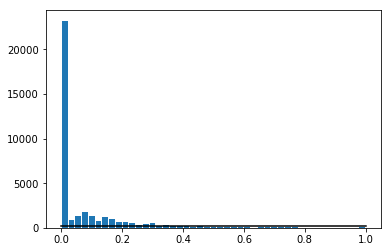

In [4]:
# print a histogram to see which steering angle ranges are most overrepresented
min_sample_treshold = 150
num_bins = 45
avg_samples_per_bin = len(df['steering'])/num_bins
hist, bins = np.histogram(np.abs(df['steering']), num_bins)
width = 0.85 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((0, np.max(df['steering'])), (min_sample_treshold, min_sample_treshold), 'k-')

print(int(df['steering'].values[1]))
print(df['steering'].count())
print(hist[0])
print(bins[1]-bins[0])

In [63]:
# Better use panda to filter the data : much faster than using the array
start = 0. #Starting steering value
bin_n = 900# wanted amount of sample within a steering range 
num_sub = 25
balanced = pd.DataFrame()
# Iterate from 0 to 1 [steering] by step of 1/45
for end in np.linspace(0,1, num_sub) : 
    # save in df_range the steering values comprises within start and end range. 
    # May use np.absolute(df.steering).between(-0.5, 0.5, inclusive=False) but multiplies some samples
    df_range = df[((np.absolute(df.steering) >= start) & (np.absolute(df.steering) < end))]
    # if there is data
    if (df_range.shape[0]) is not 0:
        # Minimum between the wanted number of samples within the steering range 
        # and the df_range size (samples within the actual df)
        range_n = min(bin_n, df_range.shape[0])
        # Stores in DataFrame balanced range_n amount of random samples 
        balanced = pd.concat([balanced,df_range.sample(range_n)])
        #balanced = balanced.append(balanced, ignore_index= True)
    else : 
        # print('DID NOT')
        pass
    start = end

center      8955
left        8955
right       8955
steering    8955
throttle    8955
brake       8955
speed       8955
dtype: int64


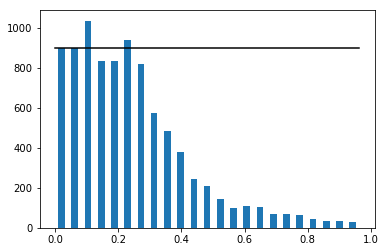

In [64]:
# remove last value of sterring (strange behavior of my data (??))
balanced = balanced.drop(balanced[(np.abs(balanced.steering) >= 0.97) & (np.abs(balanced.steering) < 1)].index)
print(balanced.count())

# print a histogram to see which steering angle ranges are most overrepresented
min_sample_treshold = bin_n
num_bins = len(np.linspace(0,1, 23))
avg_samples_per_bin = len(balanced['steering'])/num_bins
hist, bins = np.histogram(np.abs(balanced['steering']), num_bins)
width = 0.5 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((0, np.max(balanced['steering'])), (min_sample_treshold, min_sample_treshold), 'k-')

### helper functions 

#### Preprocessing

Cropping the images

<i>Inspired from [Navoshta](https://github.com/navoshta/behavioral-cloning)</i>

In [58]:
def preprocess_image(image, top_offset=0.375, bottom_offset=0.125):
    # Convert to YUV
    #image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
    # Cropping the image
    top = int(top_offset * image.shape[0])
    bottom = int(bottom_offset * image.shape[0])
    image = sktransform.resize(image[top:-bottom,:],(32,128,3), mode='constant')
    # Apply gaussian blur
    image = cv2.GaussianBlur(image,(3,3),0)
    return image 

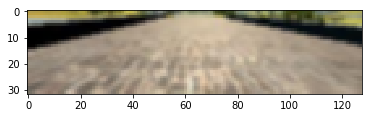

In [59]:
temp = mpimg.imread('./data/IMG/center_2016_12_01_13_30_48_287.jpg')
temp2 = preprocess_image(temp)
plt.imshow(temp2)

#### Generators

<i>Copied from [Navoshta](https://github.com/navoshta/behavioral-cloning)</i>

In [60]:
cameras = ['left','center','right']
cameras_steering_correction=[.25, .0, -.25]

# data : input panda data
def generate_data(data, root_path):
    while True : 
        # Generate random batch of indices 
        indices = np.random.permutation(data.count()[0])
        batch_size = 128 
        # Travel each batch till the end of indices
        for batch in range (0,len(indices),batch_size):
            batch_indices = indices[batch:(batch+batch_size)]
            # initiate output arrays
            #x = np.empty([0,66,200,3], dtype=np.float32)
            x = np.empty([0,32,128,3], dtype=np.float32)
            y = np.empty([0], dtype=np.float32)
            # Travel each indices coutained within the batch 
            # Read and process each image of the data
            for i in batch_indices: 
                # Randomly select camera
                camera = np.random.randint(len(cameras))
                # Read frame image and work out steering angle
                image = mpimg.imread(os.path.join(root_path, data[cameras[camera]].values[i].strip()))
                angle = data.steering.values[i] + cameras_steering_correction[camera]
                # add shadow here
                h, w = image.shape[0], image.shape[1]
                [x1, x2] = np.random.choice(w, 2, replace=False)
                k = h / (x2 - x1)
                b = - k * x1
                for i in range(h):
                    c = int((i - b) / k)
                    image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
                # Randomly shift up and down while preprocessing
                v_delta = .05
                image = preprocess_image(image, top_offset = np.random.uniform(.375 - v_delta, .375 + v_delta), 
                                   bottom_offset = np.random.uniform(.125 - v_delta, .125 + v_delta))
                # Append to batch
                x = np.append(x, [image], axis=0)
                y = np.append(y, [angle])
            # Randomly flip half of images in the batch
            flip_indices = random.sample(range(x.shape[0]), int(x.shape[0] / 2))
            x[flip_indices] = x[flip_indices, :, ::-1, :]
            y[flip_indices] = -y[flip_indices]
            yield (x, y)

In [1]:
local_project_path = './'
local_data_path = os.path.join(local_project_path, 'data')

NameError: name 'os' is not defined

### Model

<i>Inspired from [Navoshta](https://github.com/navoshta/behavioral-cloning) and [Navoshta](https://github.com/jeremy-shannon/CarND-Behavioral-Cloning-Project)</i>

In [ ]:
if not False:
    model = Sequential()
    # Normalize
    model.add(convolutional.Convolution2D(16, 3, 3, input_shape=(32, 128, 3), activation='relu', W_regularizer=l2(0.001)))
    model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
    model.add(convolutional.Convolution2D(32, 3, 3, activation='relu', W_regularizer=l2(0.001)))
    model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
    model.add(convolutional.Convolution2D(64, 3, 3, activation='relu', W_regularizer=l2(0.001)))
    model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
    model.add(core.Flatten())
    model.add(core.Dense(500, activation='relu'))
    model.add(core.Dropout(.5))
    model.add(core.Dense(100, activation='relu'))
    model.add(core.Dropout(.25))
    model.add(core.Dense(20, activation='relu'))
    model.add(core.Dense(1))
    model.compile(optimizer=Adam(lr=1e-04), loss='mse')

    # initialize generators
    df_train, df_valid = train_test_split(balanced, test_size=0.2, random_state=40)

    checkpoint = ModelCheckpoint('model_{epoch:02d}.h5', save_weights_only=False)

    #history = model.fit(X, y, batch_size=128, nb_epoch=5, validation_split=0.2, verbose=2)
    history = model.fit_generator(generate_data(df_train, local_data_path),
                                  samples_per_epoch=df_train.shape[0], nb_epoch=20,
                                  validation_data=generate_data(df_valid, local_data_path),
                                  callbacks=[checkpoint],
                                  nb_val_samples=df_valid.shape[0])
    # print('Test Loss:', model.evaluate_generator(test_gen, 128))

    print(model.summary())
    model.save_weights('./model_.h5')

Epoch 1/20
7164/7164 [==============================] - 54s - loss: 0.1950 - val_loss: 0.1882
Epoch 2/20
7164/7164 [==============================] - 47s - loss: 0.1719 - val_loss: 0.1435
Epoch 3/20
7164/7164 [==============================] - 46s - loss: 0.1410 - val_loss: 0.1283
Epoch 4/20
7164/7164 [==============================] - 45s - loss: 0.1243 - val_loss: 0.1208
Epoch 5/20
7164/7164 [==============================] - 47s - loss: 0.1139 - val_loss: 0.1078
Epoch 6/20
7164/7164 [==============================] - 47s - loss: 0.1065 - val_loss: 0.0993
Epoch 7/20
7164/7164 [==============================] - 46s - loss: 0.1003 - val_loss: 0.0970
Epoch 8/20
7164/7164 [==============================] - 46s - loss: 0.0959 - val_loss: 0.0974
Epoch 9/20
7164/7164 [==============================] - 49s - loss: 0.0898 - val_loss: 0.0869
Epoch 10/20
7164/7164 [==============================] - 46s - loss: 0.0893 - val_loss: 0.0858
Epoch 11/20
7164/7164 [==============================] - 46

In [16]:
###### ConvNet Definintion ######
###### Usage of Keras 2 - updated from Jeremy Shannon modified nVidia CNN proposal in Keras 1.x
# for debugging purposes - don't want to mess with the model if just checkin' the data
just_checkin_the_data = False

if not just_checkin_the_data:
    model = Sequential()

    # Normalize
    model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(66,200,3)))

    # Add three 5x5 convolution layers (output depth 24, 36, and 48), each with 2x2 stride
    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding='valid', kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Conv2D(36, (5, 5), strides=(2, 2), padding='valid', kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Conv2D(48, (5, 5), strides=(2, 2), padding='valid', kernel_regularizer=l2(0.001)))
    model.add(ELU())

    #model.add(Dropout(0.50))
    
    # Add two 3x3 convolution layers (output depth 64, and 64)
    model.add(Conv2D(64, (3, 3), padding='valid', kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Conv2D(64, (3, 3), padding='valid', kernel_regularizer=l2(0.001)))
    model.add(ELU())

    # Add a flatten layer
    model.add(Flatten())

    # Add three fully connected layers (depth 100, 50, 10), tanh activation (and dropouts)
    model.add(Dense(100, kernel_regularizer=l2(0.001)))
    model.add(ELU())
    #model.add(Dropout(0.50))
    model.add(Dense(50, kernel_regularizer=l2(0.001)))
    model.add(ELU())
    #model.add(Dropout(0.50))
    model.add(Dense(10, kernel_regularizer=l2(0.001)))
    model.add(ELU())
    #model.add(Dropout(0.50))

    # Add a fully connected output layer
    model.add(Dense(1))

    # Compile and train the model, 
    model.compile(optimizer=Adam(lr=1e-4), loss='mse')

    ############  just for tweaking model ##############
    # pulling out 128 random samples and training just on them, to make sure the model is capable of overfitting
    # indices_train = np.random.randint(0, len(image_paths_train), 128)
    # indices_test = np.random.randint(0, len(image_paths_test), 12)
    # image_paths_train = image_paths_train[indices_train]
    # angles_train = angles_train[indices_train]
    # image_paths_test = image_paths_test[indices_test]
    # angles_test = angles_test[indices_test]
    #############################################################
    
    # initialize generators
    df_train, df_valid = train_test_split(balanced, test_size=0.2, random_state=40)

    checkpoint = ModelCheckpoint('model{epoch:02d}.h5', save_weights_only=False)

    #history = model.fit(X, y, batch_size=128, nb_epoch=5, validation_split=0.2, verbose=2)
    history = model.fit_generator(generate_data(df_train, local_data_path),
                                  steps_per_epoch=df_train.shape[0], epochs=1,
                                  validation_data=generate_data(df_valid, local_data_path),
                                  callbacks=[checkpoint],
                                  validation_steps=df_valid.shape[0])
    # print('Test Loss:', model.evaluate_generator(test_gen, 128))

    print(model.summary())
    model.save_weights('./model.h5')

TypeError: __init__() missing 1 required positional argument: 'nb_col'

In [25]:
if not just_checkin_the_data:
    model = Sequential()
    # Normalize
    model.add(convolutional.Convolution2D(16, 3, 3, input_shape=(32, 128, 3), activation='relu'))
    model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
    model.add(convolutional.Convolution2D(32, 3, 3, activation='relu'))
    model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
    model.add(convolutional.Convolution2D(64, 3, 3, activation='relu'))
    model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
    model.add(core.Flatten())
    model.add(core.Dense(500, activation='relu'))
    model.add(core.Dropout(.5))
    model.add(core.Dense(100, activation='relu'))
    model.add(core.Dropout(.25))
    model.add(core.Dense(20, activation='relu'))
    model.add(core.Dense(1))
    model.compile(optimizer=Adam(lr=1e-4), loss='mse')

    # initialize generators
    df_train, df_valid = train_test_split(balanced, test_size=0.2, random_state=40)

    checkpoint = ModelCheckpoint('model{epoch:02d}.h5', save_weights_only=False)

    #history = model.fit(X, y, batch_size=128, nb_epoch=5, validation_split=0.2, verbose=2)
    history = model.fit_generator(generate_data(df_train, local_data_path),
                                  samples_per_epoch=df_train.shape[0], nb_epoch=1,
                                  validation_data=generate_data(df_valid, local_data_path),
                                  callbacks=[checkpoint],
                                  validation_steps=df_valid.shape[0])
    # print('Test Loss:', model.evaluate_generator(test_gen, 128))

    print(model.summary())
    model.save_weights('./model.h5')

TypeError: Received unknown keyword arguments: {'validation_steps': 807}